<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.3.1
GPU detected: []


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [2]:
data = pd.read_csv('ner_dataset.csv', encoding = 'latin')
data = data.fillna(method='ffill')
data.tail(20)

,Sentence #,Word,POS,Tag
1048555,Sentence: 47957,.,.,O
1048556,Sentence: 47958,They,PRP,O
1048557,Sentence: 47958,say,VBP,O
1048558,Sentence: 47958,not,RB,O
1048559,Sentence: 47958,all,DT,O
1048560,Sentence: 47958,of,IN,O
1048561,Sentence: 47958,the,DT,O
1048562,Sentence: 47958,rockets,NNS,O
1048563,Sentence: 47958,exploded,VBD,O
1048564,Sentence: 47958,upon,IN,O


In [3]:
print("Unique Words in Corpus: ", data["Word"].nunique())
print("Unique Tags in Corpus: ", data["Tag"].nunique())

Unique Words in Corpus:  35178
Unique Tags in Corpus:  17


In [4]:
words = list(set(data['Word'].values))
words.append("ENDPAD")
num_words = len(words)
num_words

35179

In [5]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)
num_tags

17

### Task 3: Retrieve Sentences and Corresponsing Tags

In [6]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w, p, t) for w, p, t in zip (s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [7]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [8]:
sentences[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [9]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [10]:
word2idx

{'finds': 1,
 'Manuel': 2,
 'Taylor': 3,
 'low': 4,
 'Cups': 5,
 'Jordanian-American': 6,
 'disability': 7,
 'Rhee': 8,
 'Testifying': 9,
 'Gerolsteiner': 10,
 'fisherman': 11,
 'Drapchi': 12,
 'Sculptor': 13,
 'underscoring': 14,
 'hearings': 15,
 'GBAGBO': 16,
 'secede': 17,
 'Antonchyk': 18,
 'Leonardo': 19,
 'Fujimori': 20,
 'RDX': 21,
 'Chilean': 22,
 'policymaking': 23,
 'longest-serving': 24,
 '12-kilometer-high': 25,
 'Kyaw': 26,
 'interstate': 27,
 'Located': 28,
 're-write': 29,
 'blown': 30,
 'Namibian': 31,
 'worse-than-usual': 32,
 'virtually': 33,
 'Rutshuru': 34,
 'etched': 35,
 'venomous': 36,
 'Robben': 37,
 'rehearsing': 38,
 'ITV': 39,
 'Deuce': 40,
 'Campbell': 41,
 'Anatoly': 42,
 'Maref': 43,
 'Sanjaya': 44,
 'powersharing': 45,
 'stuffing': 46,
 '1,675': 47,
 'CNBC': 48,
 'concides': 49,
 'focusing': 50,
 'Brazilian': 51,
 'tribally': 52,
 'sites': 53,
 'classified': 54,
 'Base': 55,
 'undefeated': 56,
 'offstage': 57,
 '2,500': 58,
 'martyrs': 59,
 'duties': 60,

### Task 5: Padding Input Sentences and Creating Train/Test Splits

<function matplotlib.pyplot.show(*args, **kw)>

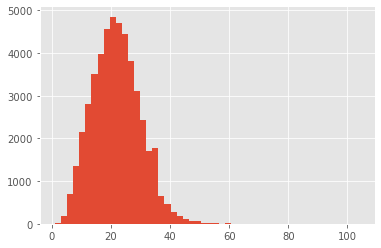

In [11]:
plt.hist([len(s) for s in sentences], bins = 50)
plt.show

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]]for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences = X, padding = 'post', value = num_words - 1)
X

Y = [[tag2idx[w[2]]for w in s] for s in sentences]
Y = pad_sequences(maxlen = max_len, sequences = Y, padding = 'post', value = tag2idx['O'])
Y = [to_categorical(i, num_classes=num_tags) for i in Y]

In [13]:
from sklearn.model_selection import  train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [14]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [15]:
input_word = Input(shape=(max_len, ))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

### Task 7: Train the Model

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [28]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    x_train, np.array(y_train), 
    validation_split = 0.2,
    batch_size = 32,
    epochs = 3,
    verbose = 1
)

Epoch 1/3
1080/1080 [==============================] - 87s 80ms/step - loss: 0.0213 - accuracy: 0.9931 - val_loss: 0.0519 - val_accuracy: 0.9852
Epoch 2/3
1080/1080 [==============================] - 93s 86ms/step - loss: 0.0190 - accuracy: 0.9937 - val_loss: 0.0539 - val_accuracy: 0.9852
Epoch 3/3
1080/1080 [==============================] - 95s 88ms/step - loss: 0.0170 - accuracy: 0.9944 - val_loss: 0.0582 - val_accuracy: 0.9845


### Task 8: Evaluate Named Entity Recognition Model

In [25]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 1s 9ms/step - loss: 0.0511 - accuracy: 0.9856


[0.05113213136792183, 0.985588014125824]

In [26]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print('-'*30)

for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
The            O	O
loss           O	O
of             O	O
Choudhury      B-geo	B-geo
,              O	O
who            O	O
was            O	O
popular        O	O
with           O	O
players        O	O
,              O	O
has            O	O
apparently     O	O
negatively     O	O
impacted       O	O
the            O	O
team           O	O
.              O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
blaze          O	O
bl